# FSRS4Anki v1.5.0 Simulator

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-spaced-repetition/fsrs4anki/blob/v1.5.0/fsrs4anki_simulator.ipynb)

In [1]:
defaultDifficulty = 4.6179
defaultStability = 2.5636
difficultyDecay = -0.5913
stabilityDecay = -0.1382
retrievabilityFactor = 1.1951
increaseFactor = 3.201
lapsesBase = -0.0562

requestRetention = 0.9  # recommended setting: 0.8 ~ 0.9
maximumInterval = 36500
easyBonus = 1.3
hardInterval = 1.2

new_cards_limits = 20
review_limits = 1000

learn_days = 200
deck_size = 5000

recall_repetitions = 1
forget_repetitions = 2
new_repetitions = 2
target_stability = 360
moving_average_period = 14


In [2]:
import torch
import random
import os
import time
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from torch import nn


In [3]:
import sqlite3
from importlib.metadata import distribution
filename = "ALL__Learning.apkg"
# Extract the collection file or deck file to get the .anki21 database.
with zipfile.ZipFile(f'./{filename}', 'r') as zip_ref:
    zip_ref.extractall('./')
    print("Extract successfully!")
if os.path.isfile("collection.anki21b"):
    os.remove("collection.anki21b")
    raise Exception(
        "Please export the file with `support older Anki versions` if you use the latest version of Anki.")
elif os.path.isfile("collection.anki21"):
    con = sqlite3.connect("collection.anki21")
elif os.path.isfile("collection.anki2"):
    con = sqlite3.connect("collection.anki2")
else:
    raise Exception("Collection not exist!")
cur = con.cursor()
res = cur.execute("SELECT * FROM revlog")
revlog = res.fetchall()

df = pd.DataFrame(revlog)
df.columns = ['id', 'cid', 'usn', 'ease', 'ivl',
              'last_lvl', 'factor', 'time', 'type']

df = df[(df['cid'] <= time.time() * 1000) &
        (df['id'] <= time.time() * 1000)].copy()
df.sort_values(by=['cid', 'id'], inplace=True, ignore_index=True)

type_sequence = np.array(df['type'])
type_block = dict()
type_count = dict()
last_t = type_sequence[0]
type_block[last_t] = 1
type_count[last_t] = 1
for t in type_sequence[1:]:
    type_count[t] = type_count.setdefault(t, 0) + 1
    if t != last_t:
        type_block[t] = type_block.setdefault(t, 0) + 1
    last_t = t
new_repetitions = type_count[0]/type_block[0] + 1
forget_repetitions = type_count[2]/type_block[2] + 1

new_card_revlog = df[df['factor'] == 0]
new_card_rating_distribution = new_card_revlog.groupby(
    'ease')['id'].count()/new_card_revlog['id'].count()
recall_card_revlog = df[(df['type'] == 1) & (df['ease'] != 1)]
recall_card_rating_distribution = recall_card_revlog.groupby(
    'ease')['id'].count()/recall_card_revlog['id'].count()


def generate_rating(review_type):
    if review_type == 'new':
        distribution = new_card_rating_distribution
    elif review_type == 'recall':
        distribution = recall_card_rating_distribution
    return random.choices(distribution.index.values, weights=distribution.values)[0]


Extract successfully!


In [4]:
class FSRS(nn.Module):
    def __init__(self):
        super(FSRS, self).__init__()
        self.f_s = nn.Parameter(torch.FloatTensor([defaultStability]))
        # init stability
        self.f_d = nn.Parameter(torch.FloatTensor([defaultDifficulty]))
        # init difficulty
        self.s_w = nn.Parameter(torch.FloatTensor(
            [increaseFactor, difficultyDecay, stabilityDecay, retrievabilityFactor, lapsesBase]))
        self.zero = torch.FloatTensor([0.0])

    def forward(self, x, s, d, l):
        '''
        :param x: [review interval, review response]
        :param s: stability
        :param d: difficulty
        :param l: lapses
        :return:
        '''
        if torch.equal(s, torch.FloatTensor([0.0])):
            # first learn, init memory states
            next_s = self.f_s[0] * 0.25 * torch.pow(2, x[1] - 1)
            next_d = self.f_d[0] - x[1] + 3
            next_l = torch.relu(2-x[1])
        else:
            r = torch.exp(np.log(0.9) * x[0] / s)
            next_s = (1 - torch.relu(2-x[1])) * s * \
                (1 + torch.exp(self.s_w[0]) * torch.pow(d + 0.1, self.s_w[1]) *
                 torch.pow(s, self.s_w[2]) *
                 (torch.exp((1 - r) * self.s_w[3]) - 1)) + \
                torch.relu(2-x[1]) * self.f_s[0] * torch.exp(self.s_w[4] * l)
            next_d = torch.relu(d + r - 0.25 * torch.pow(2, x[1] - 1) + 0.1)
            next_l = l + torch.relu(2-x[1])
        return next_s, next_d, next_l

    def loss(self, s, t, r):
        return - (r * np.log(0.9) * t / s + (1 - r) * torch.log(1 - torch.exp(np.log(0.9) * t / s)))


def lineToTensor(line):
    ivl = line[0].split(',')
    response = line[1].split(',')
    tensor = torch.zeros(len(response), 2)
    for li, response in enumerate(response):
        tensor[li][0] = int(ivl[li])
        tensor[li][1] = int(response)
    return tensor


In [5]:
class Collection:
    def __init__(self):
        self.model = FSRS()

    def states(self, t_history, r_history):
        with torch.no_grad():
            line_tensor = lineToTensor(
                list(zip([str(t_history)], [str(r_history)]))[0])
            output_t = [(self.model.zero, self.model.zero, self.model.zero)]
            for input_t in line_tensor:
                output_t.append(self.model(input_t, *output_t[-1]))
            return output_t[-1]

    def next_states(self, states, t, r):
        with torch.no_grad():
            return self.model(torch.FloatTensor([t, r]), *states)

    def init(self):
        t = 0
        r = generate_rating('new')
        p = round(new_card_rating_distribution[r], 2)
        new_states = self.states(t, r)
        return r, t, p, new_states


In [6]:
feature_list = ['difficulty', 'stability', 'retrievability', 'delta_t', 'reps', 'lapses', 'last_date', 'due',
                'r_history', 't_history', 'p_history', 'states', 'repetitions']
dtypes = np.dtype([
    ('difficulty', float),
    ('stability', float),
    ('retrievability', float),
    ('delta_t', int),
    ('reps', int),
    ('lapses', int),
    ('last_date', int),
    ('due', int),
    ('r_history', str),
    ('t_history', str),
    ('p_history', str),
    ('states', object),
    ('repetitions', int)
])
field_map = {key: i for i, key in enumerate(feature_list)}


100%|██████████| 200/200 [00:16<00:00, 11.82it/s]


acc learn 4000
meet target 0


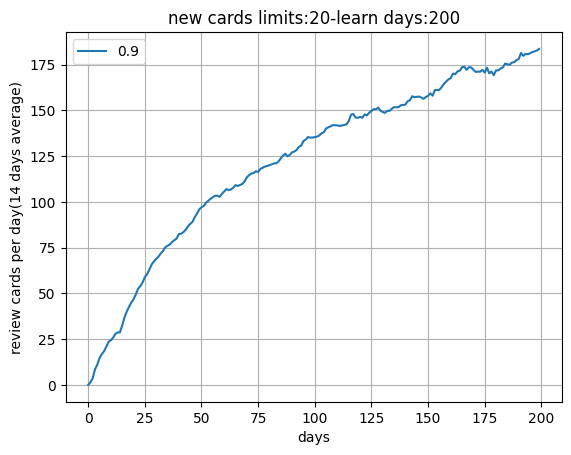

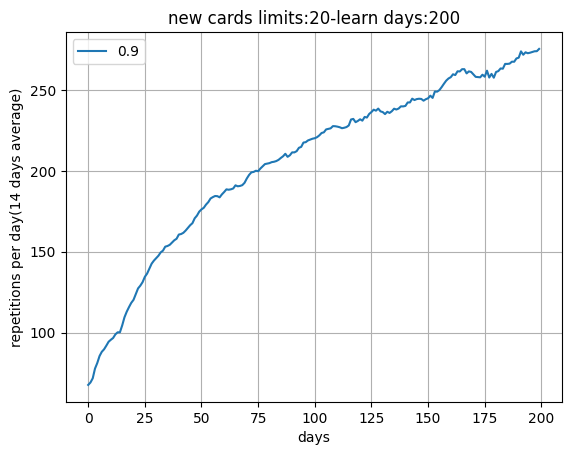

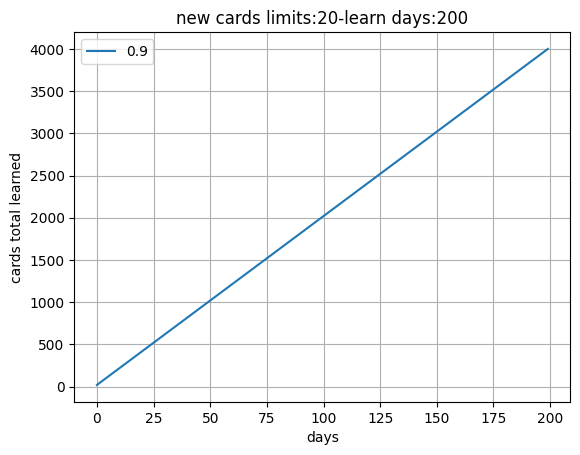

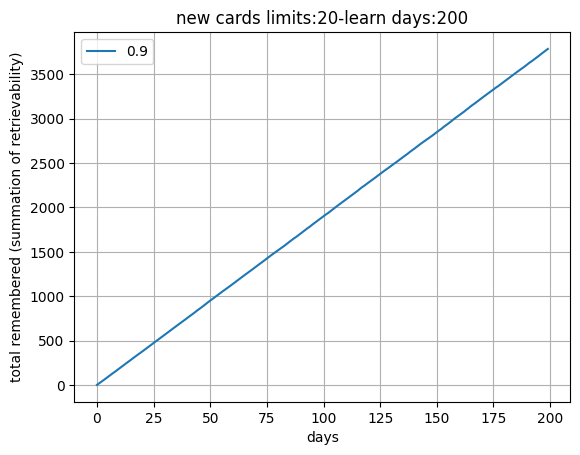

In [7]:
from hashlib import new


new_card_per_day = np.array([0.0] * learn_days)
new_card_per_day_average_per_period = np.array([0.0] * learn_days)
review_card_per_day = np.array([0.0] * learn_days)
review_card_per_day_average_per_period = np.array([0.0] * learn_days)
repetitions_per_day = np.array([0.0] * learn_days)
repetitions_per_day_average_per_period = np.array([0.0] * learn_days)

learned_per_day = np.array([0.0] * learn_days)
total_remembered_per_day = np.array([0.0] * learn_days)
meet_target_per_day = np.array([0.0] * learn_days)

card = pd.DataFrame(np.full(deck_size, np.nan, dtype=dtypes),
                    index=range(deck_size), columns=feature_list)
card['reps'] = 0
card['lapses'] = 0
card['due'] = learn_days

meet_target = 0

student = Collection()
random.seed(2022)

intervalModifier = np.log(requestRetention) / np.log(0.9)


def constrain_interval(stability):
    return min(max(1, round(stability * intervalModifier)), maximumInterval)


def fsrs4anki_scheduler(last_stability, stability, rating, lapses):
    again_interval = constrain_interval(defaultStability * np.exp(lapsesBase * lapses))
    hard_interval = constrain_interval(last_stability * hardInterval)
    good_interval = max(constrain_interval(stability), hard_interval + 1)
    easy_interval = max(constrain_interval(stability * easyBonus), good_interval + 1)
    if rating == 1:
        return again_interval
    if rating == 2:
        return hard_interval
    if rating == 3:
        return good_interval
    if rating == 4:
        return easy_interval
    return maximumInterval


for day in tqdm(range(learn_days)):
    reviewed = 0
    learned = 0
    review_repetitions_today = 0
    learn_repetitions_today = 0

    card["delta_t"] = day - card["last_date"]
    card["retrievability"] = np.exp(
        np.log(0.9) * card["delta_t"] / card["stability"])
    need_review = card[card['due'] <= day].index
    for idx in need_review:
        if reviewed >= review_limits:
            break

        reviewed += 1
        card.iat[idx, field_map['last_date']] = day
        ivl = card.iat[idx, field_map['delta_t']]
        card.iat[idx, field_map['t_history']] += f',{ivl}'

        stability = card.iat[idx, field_map['stability']]
        retrievability = card.iat[idx, field_map['retrievability']]
        card.iat[idx, field_map['p_history']] += f',{retrievability:.2f}'
        reps = card.iat[idx, field_map['reps']]
        lapses = card.iat[idx, field_map['lapses']]
        states = card.iat[idx, field_map['states']]

        if random.random() < retrievability:
            review_repetitions_today += recall_repetitions

            rating = generate_rating('recall')
            card.iat[idx, field_map['r_history']] += f',{rating}'
            new_states = student.next_states(states, ivl, rating)
            new_stability = float(new_states[0])
            new_difficulty = float(new_states[1])
            card.iat[idx, field_map['stability']] = new_stability
            card.iat[idx, field_map['difficulty']] = new_difficulty
            card.iat[idx, field_map['states']] = new_states
            card.iat[idx, field_map['reps']] = reps + 1
            card.iat[idx, field_map['repetitions']] += recall_repetitions

            if new_stability >= target_stability:
                meet_target += 1
                card.iat[idx, field_map['stability']] = np.inf
                card.iat[idx, field_map['due']] = np.inf
                continue

            delta_t = fsrs4anki_scheduler(stability, new_stability, rating, lapses)
            card.iat[idx, field_map['due']] = day + delta_t

        else:
            review_repetitions_today += forget_repetitions

            rating = 1
            card.iat[idx, field_map['r_history']] += f',{rating}'

            new_states = student.next_states(states, ivl, 1)
            new_stability = float(new_states[0])
            new_difficulty = float(new_states[1])

            if new_stability >= target_stability:
                meet_target += 1
                card.iat[idx, field_map['stability']] = np.inf
                card.iat[idx, field_map['due']] = np.inf
                continue

            card.iat[idx, field_map['stability']] = new_stability
            card.iat[idx, field_map['difficulty']] = new_difficulty
            card.iat[idx, field_map['states']] = new_states

            reps = 0
            lapses = lapses + 1

            card.iat[idx, field_map['reps']] = reps
            card.iat[idx, field_map['lapses']] = lapses

            delta_t = fsrs4anki_scheduler(stability, new_stability, rating, lapses)
            card.iat[idx, field_map['due']] = day + delta_t
            card.iat[idx, field_map['repetitions']] += recall_repetitions

    need_learn = card[card['stability'].isna()].index

    for idx in need_learn:
        if learned >= new_cards_limits:
            break
        learned += 1
        learn_repetitions_today += new_repetitions
        card.iat[idx, field_map['last_date']] = day

        card.iat[idx, field_map['reps']] = 1
        card.iat[idx, field_map['lapses']] = 0

        r, t, p, new_states = student.init()
        new_stability = float(new_states[0])
        new_difficulty = float(new_states[1])

        card.iat[idx, field_map['r_history']] = str(r)
        card.iat[idx, field_map['t_history']] = str(t)
        card.iat[idx, field_map['p_history']] = str(p)
        card.iat[idx, field_map['stability']] = new_stability
        card.iat[idx, field_map['difficulty']] = new_difficulty
        card.iat[idx, field_map['states']] = new_states

        delta_t = constrain_interval(new_stability)
        card.iat[idx, field_map['due']] = day + delta_t
        card.iat[idx, field_map['repetitions']] = new_repetitions

    new_card_per_day[day] = learned
    review_card_per_day[day] = reviewed
    learned_per_day[day] = learned_per_day[day - 1] + learned
    repetitions_per_day[day] = review_repetitions_today + learn_repetitions_today

    if day >= moving_average_period:
        new_card_per_day_average_per_period[day] = np.true_divide(
            new_card_per_day[day - moving_average_period:day].sum(), moving_average_period)
        review_card_per_day_average_per_period[day] = np.true_divide(
            review_card_per_day[day - moving_average_period:day].sum(), moving_average_period)
        repetitions_per_day_average_per_period[day] = np.true_divide(
            repetitions_per_day[day - moving_average_period:day].sum(), moving_average_period)
    else:
        new_card_per_day_average_per_period[day] = np.true_divide(
            new_card_per_day[:day + 1].sum(), day + 1)
        review_card_per_day_average_per_period[day] = np.true_divide(
            review_card_per_day[:day + 1].sum(), day + 1)
        repetitions_per_day_average_per_period[day] = np.true_divide(
            repetitions_per_day[:day + 1].sum(), day + 1)

    total_remembered_per_day[day] = card['retrievability'].sum()
    meet_target_per_day[day] = meet_target

total_learned = int(sum(new_card_per_day))
total_repetitions = int(sum(repetitions_per_day))


plt.figure(1)
plt.plot(review_card_per_day_average_per_period, label=f'{requestRetention}')
plt.figure(2)
plt.plot(repetitions_per_day_average_per_period, label=f'{requestRetention}')
plt.figure(3)
plt.plot(learned_per_day, label=f'{requestRetention}')
plt.figure(4)
plt.plot(total_remembered_per_day, label=f'{requestRetention}')

print('acc learn', total_learned)
print('meet target', meet_target)

save = card[card['retrievability'] > 0].copy()
save['stability'] = round(save['stability'], 2)
save['retrievability'] = round(save['retrievability'], 2)
save['difficulty'] = round(save['difficulty'], 2)

save.to_csv(f'./simulator-{round(requestRetention * 100)}%.tsv', index=False, sep='\t')

plt.figure(1)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel(f"review cards per day({moving_average_period} days average)")
plt.legend()
plt.grid(True)
plt.figure(2)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel(f"repetitions per day({moving_average_period} days average)")
plt.legend()
plt.grid(True)
plt.figure(3)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel(f"cards total learned")
plt.legend()
plt.grid(True)
plt.figure(4)
plt.title(f"new cards limits:{new_cards_limits}-learn days:{learn_days}")
plt.xlabel("days")
plt.ylabel("total remembered (summation of retrievability)")
plt.legend()
plt.grid(True)
plt.show()
plt.close('all')
